# AI in Actuary Project by Keith TANG

## Running Configuration
- Python 4.0.8
- TensorFlow 2.17

In [1]:
import time
import numpy as np
import pandas as pd
import random

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Reshape, Embedding, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

# Part 1 Data Cleaning and Validation

In [2]:
df = pd.read_csv("AustralianVehiclePrices.csv")
df.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


## 1.1 Data Validation

### 1.1.1 Car Brand and Model Validation Using external dataset

In [3]:
unique_brand = df["Brand"].unique()
#sorted(unique_brand, key=str)
df["Model"].value_counts().head(5)

Model
Hilux          430
Corolla        405
Ranger         398
Landcruiser    370
I30            366
Name: count, dtype: int64

In [4]:
validset = pd.read_csv('https://query.data.world/s/5gzse4komw5ymziqismmmblcqabalt?dws=00000')
validset.head(3)

,ID,Model Year,Make,Model,Estimated Annual Petrolum Consumption (Barrels),Fuel Type 1,City MPG (Fuel Type 1),Highway MPG (Fuel Type 1),Combined MPG (Fuel Type 1),Fuel Type 2,...,Engine Description,Transmission,Vehicle Class,Time to Charge EV (hours at 120v),Time to Charge EV (hours at 240v),Range (for EV),City Range (for EV - Fuel Type 1),City Range (for EV - Fuel Type 2),Hwy Range (for EV - Fuel Type 1),Hwy Range (for EV - Fuel Type 2)
0,1,1985,Alfa Romeo,Spider Veloce 2000,14.167143,Regular Gasoline,19,25,21,NaN,...,(FFS),Manual 5-spd,Two Seaters,0,0.0,0,0.0,0.0,0.0,0.0
1,2,1985,Bertone,X1/9,13.523182,Regular Gasoline,20,26,22,NaN,...,NaN,Manual 5-spd,Two Seaters,0,0.0,0,0.0,0.0,0.0,0.0
2,3,1985,Chevrolet,Corvette,17.500588,Regular Gasoline,15,21,17,NaN,...,(350 V8) (FFS),Automatic 4-spd,Two Seaters,0,0.0,0,0.0,0.0,0.0,0.0


In [5]:
validmodel = validset["Make"].unique()
dfmodel = df["Brand"].unique()
df['is_in_validate_set'] = df['Brand'].isin(validmodel)
df['is_in_validate_set'].sum()

14290

> More than 85% of the samples in our dataset are listed in the US Department of Energy Catalogue

In [6]:
diff = list(set(dfmodel) - set(validmodel))
upper_case_dfmodel = [str(item).upper() for item in dfmodel]
upper_case_validmodel = [str(item).upper() for item in validmodel]

diff = list(set(upper_case_dfmodel) - set(upper_case_validmodel))
print(f"Australia: {len(upper_case_dfmodel)} , Validate : {len(upper_case_validmodel)}, In Australia but not in US: {len(diff)} \n")
print("Brands in Australia but not in the US:", diff)

Australia: 77 , Validate : 141, In Australia but not in US: 32 

Brands in Australia but not in the US: ['HINO', 'GWM', 'LDV', 'IVECO', 'HSV', 'LAND', 'INTERNATIONAL', 'MG', 'PROTON', 'ABARTH', 'GREAT', 'CHERY', 'ASTON', 'OPEL', 'ALFA', 'DATSUN', 'FPV', 'FOTON', 'CUPRA', 'TATA', 'GEELY', 'CITROEN', 'SKODA', 'CATERHAM', 'NAN', 'SSANGYONG', 'HOLDEN', 'HAVAL', 'PACKARD', 'ROVER', 'MCLAREN', 'INEOS']


In [7]:
diff = ['MCLAREN', 'PACKARD', 'CUPRA', 'HAVAL', 'PROTON', 'GWM', 'FPV', 'GEELY', 'DATSUN', 'IVECO', 'SSANGYONG', 'CATERHAM', 'LAND', 'CHERY', 'HOLDEN', 'ABARTH', 'NAN', 'TATA', 'HSV', 'HINO', 'SKODA', 'ROVER', 'INTERNATIONAL', 'LDV', 'ALFA', 'CITROEN', 'MG', 'GREAT', 'OPEL', 'ASTON', 'FOTON', 'INEOS']
upper_case_validmodel = ['ACURA', 'ALFA ROMEO', 'AM GENERAL', 'AMERICAN MOTORS CORPORATION', 'ASC INCORPORATED', 'ASTON MARTIN', 'AUDI', 'AURORA CARS LTD', 'AUTOKRAFT LIMITED', 'AVANTI MOTOR CORPORATION', 'AZURE DYNAMICS', 'BENTLEY', 'BERTONE', 'BILL DOVELL MOTOR CAR COMPANY', 'BITTER GMBH AND CO. KG', 'BMW', 'BMW ALPINA', 'BUGATTI', 'BUICK', 'BYD', 'CADILLAC', 'CCC ENGINEERING', 'CHEVROLET', 'CHRYSLER', 'CODA AUTOMOTIVE', 'CONSULIER INDUSTRIES INC', 'CX AUTOMOTIVE', 'DABRYAN COACH BUILDERS INC', 'DACIA', 'DAEWOO', 'DAIHATSU', 'DODGE', 'E. P. DUTTON, INC.', 'EAGLE', 'ENVIRONMENTAL RSCH AND DEVP CORP', 'EVANS AUTOMOBILES', 'EXCALIBUR AUTOS', 'FEDERAL COACH', 'FERRARI', 'FIAT', 'FISKER', 'FORD', 'GENERAL MOTORS', 'GENESIS', 'GEO', 'GMC', 'GOLDACRE', 'GRUMMAN ALLIED INDUSTRIES', 'GRUMMAN OLSON', 'HONDA', 'HUMMER', 'HYUNDAI', 'IMPORT FOREIGN AUTO SALES INC', 'IMPORT TRADE SERVICES', 'INFINITI', 'ISIS IMPORTS LTD', 'ISUZU', 'J.K. MOTORS', 'JAGUAR', 'JBA MOTORCARS, INC.', 'JEEP', 'KANDI', 'KARMA', 'KENYON CORPORATION OF AMERICA', 'KIA', 'KOENIGSEGG', 'LAFORZA AUTOMOBILE INC', 'LAMBDA CONTROL SYSTEMS', 'LAMBORGHINI', 'LAND ROVER', 'LEXUS', 'LINCOLN', 'LONDON COACH CO INC', 'LONDON TAXI', 'LOTUS', 'LUCID', 'MAHINDRA', 'MASERATI', 'MAYBACH', 'MAZDA', 'MCEVOY MOTORS', 'MCLAREN AUTOMOTIVE', 'MERCEDES-BENZ', 'MERCURY', 'MERKUR', 'MINI', 'MITSUBISHI', 'MOBILITY VENTURES LLC', 'MORGAN', 'NISSAN', 'OLDSMOBILE', 'PAGANI', 'PANOS', 'PANOZ AUTO-DEVELOPMENT', 'PANTHER CAR COMPANY LIMITED', 'PAS INC - GMC', 'PAS, INC', 'PEUGEOT', 'PININFARINA', 'PLYMOUTH', 'POLESTAR', 'PONTIAC', 'PORSCHE', 'QUANTUM TECHNOLOGIES', 'QVALE', 'RAM', 'RED SHIFT LTD.', 'RENAULT', 'RIVIAN', 'ROLLS-ROYCE', 'ROUSH PERFORMANCE', 'RUF AUTOMOBILE', 'RUF AUTOMOBILE GMBH', 'S AND S COACH COMPANY  E.P. DUTTON', 'SAAB', 'SALEEN', 'SALEEN PERFORMANCE', 'SATURN', 'SCION', 'SHELBY', 'SMART', 'SPYKER', 'SRT', 'STERLING', 'STI', 'SUBARU', 'SUPERIOR COACHES DIV E.P. DUTTON', 'SUZUKI', 'TECSTAR, LP', 'TESLA', 'TEXAS COACH COMPANY', 'TOYOTA', 'TVR ENGINEERING LTD', 'VECTOR', 'VIXEN MOTOR COMPANY', 'VOLGA ASSOCIATED AUTOMOBILE', 'VOLKSWAGEN', 'VOLVO', 'VPG', 'WALLACE ENVIRONMENTAL', 'YUGO']
df1_upper = [item.upper() for item in diff]
df2_upper = [item.upper() for item in upper_case_validmodel]

matches = [item1 for item1 in df1_upper if any(item1 in item2 for item2 in df2_upper)]
print("Matched items:", matches)
update_df = [item for item in df1_upper if item not in matches]
#print("Updated df1:", update_df)
len(update_df)

Matched items: ['MCLAREN', 'LAND', 'ROVER', 'ALFA', 'ASTON']


27

In [8]:
df['Brand_upper'] = df['Brand'].str.upper()
filtered_df = df[df['Brand_upper'].isin(update_df)]
filtered_df['Brand'].value_counts().head(10) # Australia Only

Brand
Holden       1087
MG            300
GWM           201
LDV           124
Skoda         111
Ssangyong      58
HSV            44
Iveco          37
Hino           26
Haval          22
Name: count, dtype: int64

In [9]:
df["Brand"].value_counts(normalize=True).head(5)

Brand
Toyota     0.166378
Hyundai    0.074045
Mazda      0.070460
Holden     0.064961
Ford       0.063049
Name: proportion, dtype: float64

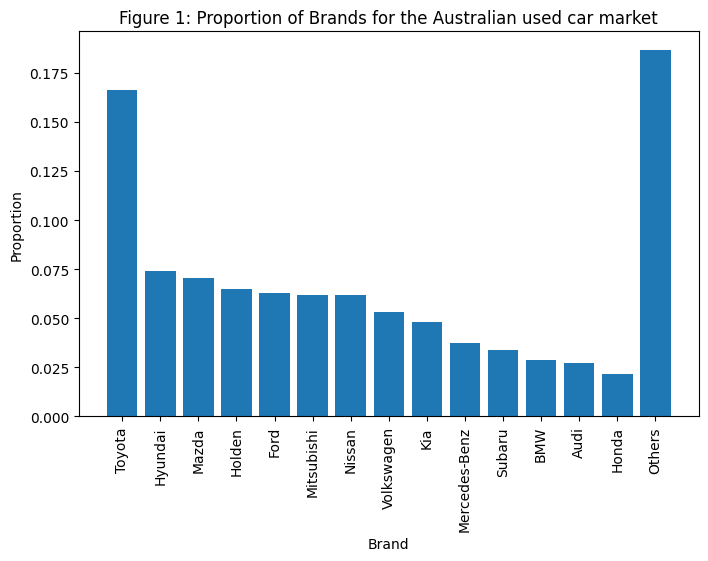

In [10]:
brand_proportions = df['Brand'].value_counts(normalize=True)
threshold = 0.02  # Example threshold
# Aggregate less common brands into 'Others'

aggregated = brand_proportions[brand_proportions >= threshold]
others = brand_proportions[brand_proportions < threshold].sum()
aggregated['Others'] = others

# Plot the data
plt.figure(figsize=(8, 5))
plt.bar(aggregated.index, aggregated.values)
plt.xlabel("Brand")
plt.ylabel("Proportion")
plt.title("Figure 1: Proportion of Brands for the Australian used car market")
plt.xticks(rotation=90)
plt.savefig("Brand_proportions.jpg")
plt.show()

In [11]:
df = df.drop(columns=["is_in_validate_set","Brand_upper"])

In [12]:
df.shape

(16734, 19)

### 1.1.2 Validating Target Values

>All 19 columns contain missing values. However, by removing 3 observations related to Price, we can reduce the number of columns with missing values to 5. Since our goal is to predict Price, it's illogical to include samples without Price in our model training.

In [13]:
df[df["Price"].isna()==True]
df = df.dropna(subset=["Price"])

In [14]:
df["Price"] = pd.to_numeric(df["Price"], errors='coerce')
df = df.dropna(subset=["Price"])

> After transforming the format of Price to numeric, we discovered that 50 samples have input 'NaN'. Therefore, we drop these samples based on the aforementioned reason.

### 1.1.3 Splitting the dataset

In [15]:
y = df["Price"]
X = df.drop("Price", axis=1)

In [16]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=2024)

## 1.2 Data Cleaning and Transformation

### 1.2.1 Limiting our data from 1998 onwards

In [17]:
X_train["Year"]=X_train["Year"].astype(int)

In [18]:
# Outliners Investigation
median = X_train["Year"].median()
percentile_1 = np.percentile(X_train["Year"], 1)
print(f"The median year is: {median}")
print(f"The 1st percentile year is: {percentile_1}")
X_train[X_train["Year"]<1998]["Year"].value_counts().sort_index(ascending=False).head(3)

The median year is: 2017.0
The 1st percentile year is: 2001.0


Year
1997    7
1996    8
1995    2
Name: count, dtype: int64

> Samples before 1998 occur less than 10 times annually, making it difficult to generate representative estimations from them. Therefore, we exclude these samples and restrict our analysis to user input from 1998 onwards.

In [19]:
X_train = X_train[X_train["Year"] > 1997]
y_train = y_train.loc[X_train.index]

In [20]:
X_train.shape, y_train.shape

((12460, 18), (12460,))

### 1.2.2 Setting `Price` Range

In [21]:
median_price = y_train.median()
percentile_price995 = np.percentile(y_train, 99.5)
print(f"The medianyear is: {median_price}")
print(f"The 99th percentile year is: {percentile_price995:.2f}")

The medianyear is: 29500.0
The 99th percentile year is: 262573.10


In [22]:
df2 = y_train[y_train > percentile_price995]
len(df2)
df2.sort_values(ascending=False).head(3)

10358    649880.0
3357     649880.0
5271     579888.0
Name: Price, dtype: float64

In [23]:
y_train = y_train[y_train < percentile_price995]
X_train = X_train.loc[y_train.index]

In [24]:
X_train.shape, y_train.shape

((12397, 18), (12397,))

> Although we have already excluded antiques such as the 1959 Ferrari priced at 1.5 million dollars, we further eliminate samples with a Price above 99.5% percentile as outliers to construct more accurate models for over 99% of our users.

### 1.2.3 Transforming `Kilometres` to continuous variable

In [25]:
X_train["Kilometres"] = pd.to_numeric(X_train["Kilometres"], errors='coerce')
X_train = X_train.dropna(subset=["Kilometres"])
y_train = y_train.loc[X_train.index]

### 1.2.4 Handling Missing values for `Car/Suv` and `BodyType`

In [26]:
X_train["Car/Suv"].value_counts()

Car/Suv
SUV                                       4445
Hatchback                                 1759
Ute / Tray                                1537
Sedan                                     1436
Wagon                                      412
                                          ... 
Lancaster Automotive Holdings New Cars       1
Carlin and Gazzard                           1
Kloster Suzuki - New                         1
Osborne Park Mazda used                      1
Sydney Luxury Motors                         1
Name: count, Length: 503, dtype: int64

> `Car/Suv`, which is supposed to contain car type information, incorporates 35% SUVs and 14% hatchbacks but has 503 unique categories. Upon investigation, we found that many of these categories include car dealer information instead of car types. By applying value_counts(), we observed up to 37 counts across 492 categories, nearly all of which are car dealers and do not represent car types. 

>The remaining 12 categories can be divided into two groups: body type (e.g., SUV and Hatchback) and condition (e.g., NEW In stock and DEMO), accounting for over 85% of the samples. Consequently, we decided to convert the car dealer information and NaN values to missing_btc.

In [27]:
X_train["Car/Suv"].value_counts()[X_train["Car/Suv"].value_counts() < 50]
#sorted(X_train["Car/Suv"].unique(),key=str)

Car/Suv
Nippon Motors                             37
Alto Blacktown MG                         32
03 **** ****\n                            27
SYC Cars                                  27
Rockdale Mazda New                        27
                                          ..
Lancaster Automotive Holdings New Cars     1
Carlin and Gazzard                         1
Kloster Suzuki - New                       1
Osborne Park Mazda used                    1
Sydney Luxury Motors                       1
Name: count, Length: 492, dtype: int64

In [28]:
X_train["Car/Suv"].value_counts()[X_train["Car/Suv"].value_counts() > 50]

Car/Suv
SUV               4445
Hatchback         1759
Ute / Tray        1537
Sedan             1436
Wagon              412
USED Dealer ad     245
Commercial         224
Coupe              181
NEW In stock        77
Convertible         69
DEMO                52
Name: count, dtype: int64

In [29]:
# Replace identified categories and NaN values with 'missing_btc'
value_counts = X_train["Car/Suv"].value_counts()
categories_to_replace = value_counts[value_counts < 50].index.tolist()
X_train["Car/Suv"] = X_train["Car/Suv"].apply(lambda x: 'missing_btc' if pd.isna(x) or x in categories_to_replace else x)

In [30]:
X_train[X_train["BodyType"].isna()==True].head(3)

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats
8385,Mitsubishi,1999,Lancer,USED Dealer ad,1999 Mitsubishi Lancer EVOLUTION VI CP9A 4CYL ...,USED,Manual,-,Other,Unleaded,-,129101.0,White / -,"Braeside, VIC",-,NaN,NaN,NaN
13540,Holden,2008,Commodore,USED Dealer ad,2008 Holden Commodore VE OMEGA,USED,Automatic,-,Other,Unleaded,-,238517.0,Grey / -,"Hamilton Hill, WA",-,NaN,NaN,NaN
11119,Toyota,2021,Camry,USED Dealer ad,2021 Toyota Camry Ascent,USED,Automatic,-,Front,Premium,-,35241.0,White / -,"Elsternwick, VIC",-,NaN,NaN,NaN


In [31]:
# Identify rows where Car/Suv is 'missing_btc' and BodyType is NaN and drop it
mixed_missing_rows = X_train[(X_train["Car/Suv"] == 'missing_btc') & (X_train["BodyType"].isna())]
X_train = X_train.drop(mixed_missing_rows.index)
y_train = y_train.drop(mixed_missing_rows.index)

In [32]:
not_equal_rows = X_train[X_train["Car/Suv"] != X_train["BodyType"]]
df_cleaned = X_train.drop(not_equal_rows.index)
df_notequal = X_train.loc[not_equal_rows.index]
#pd.set_option('display.min_rows', 200)
print(df_notequal[["Car/Suv","BodyType"]])

              Car/Suv    BodyType
5354      missing_btc         SUV
4982      missing_btc  Ute / Tray
3460      missing_btc         SUV
5235      missing_btc         SUV
8385   USED Dealer ad         NaN
...               ...         ...
606       missing_btc       Wagon
15811     missing_btc  Ute / Tray
7167      missing_btc         SUV
5304      missing_btc       Sedan
12449            DEMO       Wagon

[1873 rows x 2 columns]


> After investigation, we found that there is more information available for BodyType than for Car/SUV, so we have decided to drop Car/SUV.

In [33]:
X_train = X_train.drop(columns=["Car/Suv"])

In [34]:
X_train["BodyType"] = X_train["BodyType"].fillna('missing_btc')

### 1.2.5 Transforming Suburb Location to States

In [35]:
X_train["Location"].value_counts()

Location
Minchinbury, NSW         415
Blacktown, NSW           217
Liverpool, NSW           185
Hoppers Crossing, VIC    169
Bentley, WA              158
                        ... 
Norwood, SA                1
Dinmore, QLD               1
FAWKNER, VIC               1
East Toowoomba, QLD        1
Bowden, SA                 1
Name: count, Length: 598, dtype: int64

In [36]:
X_train["State"] = X_train["Location"].str[-3:]
# Group by the state and get the count of occurrences
state_counts = X_train.groupby("State").size()
state_counts



State
 NT      58
 SA     560
 WA    1322
ACT     294
NSW    4717
QLD    2010
TAS     163
VIC    2812
dtype: int64

In [37]:
X_train = X_train.drop(columns=["Location"])
X_train["State"] = X_train["State"].fillna('missing_state')

### 1.2.6 Handling Missing values for Doors and Seats

In [38]:
X_train["Doors"].unique()

array([' 4 Doors', ' 3 Doors', ' 5 Doors', nan, ' 2 Doors', ' 7 Seats',
       ' 5 Seats', ' 8 Seats', ' 2 Seats', ' 3 Seats', ' 9 Seats',
       ' 6 Seats', ' 12 Seats', ' 4 Seats'], dtype=object)

In [39]:
X_train["Seats"].unique()

array([' 5 Seats', ' 7 Seats', ' 2 Seats', ' 3 Seats', ' 4 Seats',
       ' 8 Seats', nan, ' 6 Seats', ' 12 Seats', ' 14 Seats', ' 9 Seats',
       ' 11 Seats'], dtype=object)

In [40]:
# Check if "Doors" includes "Seats" and compare with "Seats" column
X_train["Includes_Seats"] = X_train["Doors"].str.contains("Seats")
X_train["Equal_to_Seats"] = X_train.apply(lambda row: row["Doors"] == row["Seats"] if row["Includes_Seats"] else None, axis=1)


In [41]:
X_train.loc[X_train["Includes_Seats"]==True, "Seats"] = X_train["Doors"]
X_train.loc[X_train["Includes_Seats"]==True, "Doors"] = "missing_dr"

In [42]:
X_train["Doors"] = X_train["Doors"].fillna('missing_dr')

In [43]:
X_train = X_train.drop(columns=["Includes_Seats", "Equal_to_Seats"])

In [44]:
X_train["Doors"].value_counts()

Doors
 4 Doors      8108
 5 Doors      1846
missing_dr    1140
 2 Doors       710
 3 Doors       132
Name: count, dtype: int64

In [45]:
# verify "3 Doors" used car
X_train["Doors"] = X_train["Doors"].str.strip()
filtered_df = X_train[X_train["Doors"] == "3 Doors"]
filtered_df.head(3)

,Brand,Year,Model,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,CylindersinEngine,BodyType,Doors,Seats,State
605,Volkswagen,2019,Caddy,2019 Volkswagen Caddy SWB TSI220,USED,Automatic,"4 cyl, 1.4 L",Front,Premium,6 L / 100 km,97327.0,White / Black,4 cyl,Commercial,3 Doors,2 Seats,NSW
1021,Hyundai,2014,Veloster,2014 Hyundai Veloster SR Turbo,USED,Manual,"4 cyl, 1.6 L",Front,Unleaded,6.4 L / 100 km,137640.0,Black / -,4 cyl,Hatchback,3 Doors,4 Seats,NSW
8477,Mini,2014,Paceman,2014 Mini Paceman Cooper JCW ALL4,USED,Automatic,"4 cyl, 1.6 L",AWD,Premium,8.3 L / 100 km,87861.0,Blue / White,4 cyl,Hatchback,3 Doors,4 Seats,QLD


In [46]:
missingseats = X_train["Seats"].isna()
X_train["Seats"] = X_train["Seats"].fillna('missing_seats')

In [47]:
X_train.shape, y_train.shape

((11936, 17), (11936,))

### 1.2.7 Extracting FuelConsumption Numerical Value

In [48]:
def extract_number(value):
    import re
    match = re.match(r"(\d+\.?\d*)", value)
    return float(match.group(1)) if match else None

# Apply the function to the column
X_train['FuelConsumption'] = X_train['FuelConsumption'].apply(extract_number)
median_fuel_consumption = X_train['FuelConsumption'].median()

# Impute missing values and zeros with the median
X_train['FuelConsumption'] = X_train['FuelConsumption'].replace(0, np.nan)
X_train['FuelConsumption'] = X_train['FuelConsumption'].fillna(median_fuel_consumption)

### 1.2.8 Transformeing Engine into Cylinders and Capacity

In [49]:
# Function to extract cylinders and capacity
def extract_engine_features(engine):
    try:
        if engine == '-' or not isinstance(engine, str):
            return np.nan, np.nan
        parts = engine.split(', ')
        if len(parts) != 2:
            return np.nan, np.nan
        cyl, cap = parts
        cyl_value = int(cyl.split()[0])
        cap_value = float(cap.split()[0])
        return cyl_value, cap_value
    except Exception as e:
        return np.nan, np.nan

# Apply the function to the 'Engine' column
X_train[['Cylinders', 'Capacity']] = X_train['Engine'].apply(lambda x: pd.Series(extract_engine_features(x)))

# Handle missing values (example: fill with median or mean)
X_train['Cylinders'] = X_train['Cylinders'].fillna(X_train['Cylinders'].median())
X_train['Capacity'] = X_train['Capacity'].fillna(X_train['Capacity'].median())

X_train = X_train.drop(columns=['Engine'])

In [50]:
X_train[['Cylinders','CylindersinEngine']].head(3)

,Cylinders,CylindersinEngine
5354,4.0,4 cyl
9601,4.0,4 cyl
11017,4.0,4 cyl


In [51]:
X_train = X_train.drop(columns=['Cylinders']) #duplicated 

# Part 2 Data Visualization

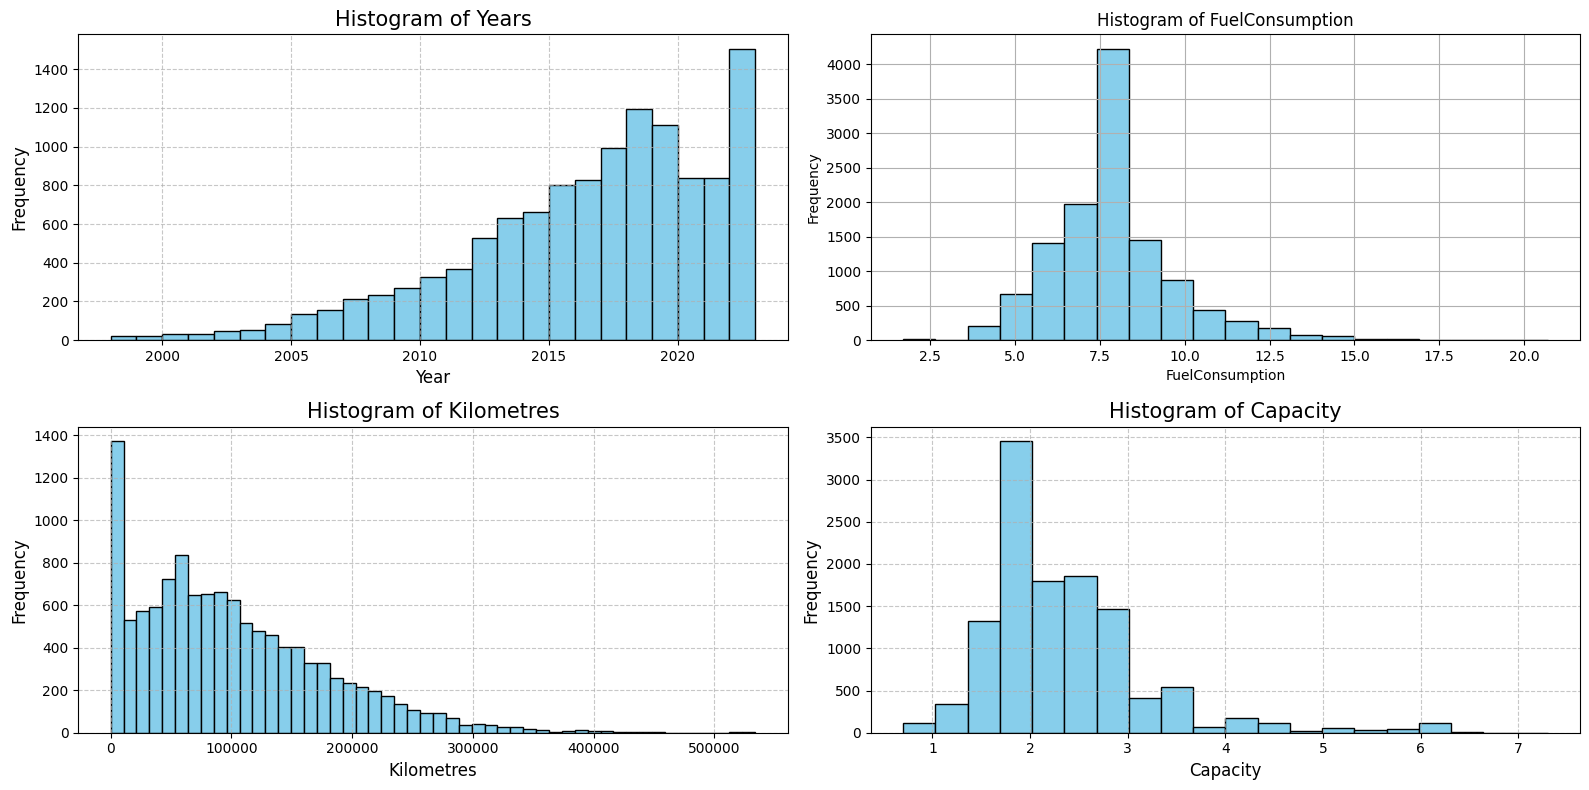

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# Histogram of Years
axes[0, 0].hist(X_train["Year"], bins=range(min(X_train["Year"]), max(X_train["Year"]) + 1), edgecolor='black', color='skyblue')
axes[0, 0].set_title("Histogram of Years", fontsize=15)
axes[0, 0].set_xlabel("Year", fontsize=12)
axes[0, 0].set_ylabel("Frequency", fontsize=12)
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Plotting the histogram for FuelConsumption
axes[0,1].hist(X_train['FuelConsumption'], bins=20, edgecolor='black', color='skyblue')
axes[0,1].set_title('Histogram of FuelConsumption')
axes[0,1].set_xlabel('FuelConsumption')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True)

# Histogram of Kilometres
axes[1, 0].hist(X_train['Kilometres'], bins=50, edgecolor='black', color='skyblue')
axes[1, 0].set_title('Histogram of Kilometres', fontsize=15)
axes[1, 0].set_xlabel('Kilometres', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# Histogram of FuelConsumption
axes[1, 1].hist(X_train['Capacity'], bins=20, edgecolor='black', color='skyblue')
axes[1, 1].set_title('Histogram of Capacity', fontsize=15)
axes[1, 1].set_xlabel('Capacity', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("distributions.jpg")
plt.show()


> The target variable is are highly right-skewed

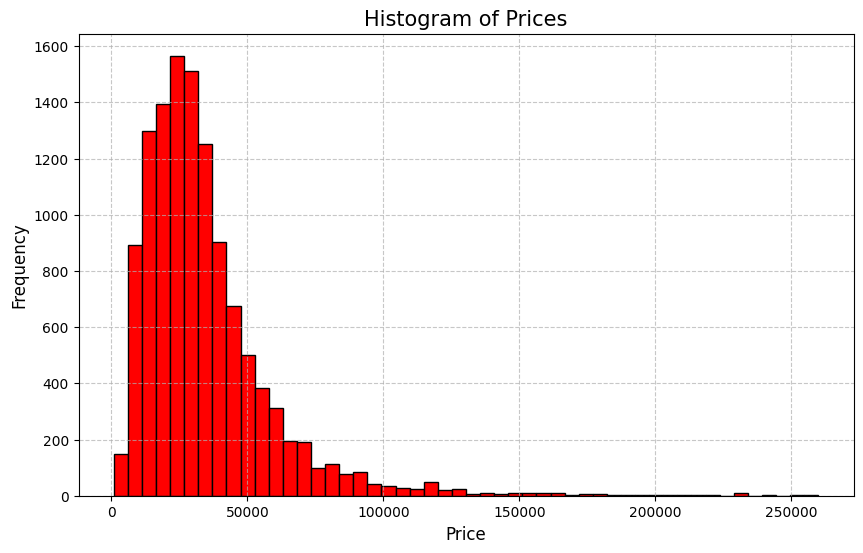

In [53]:
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=50, edgecolor='black', color='red')
plt.title('Histogram of Prices', fontsize=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

> Define our target variable as log Price

In [54]:
y_train = np.log(y_train)

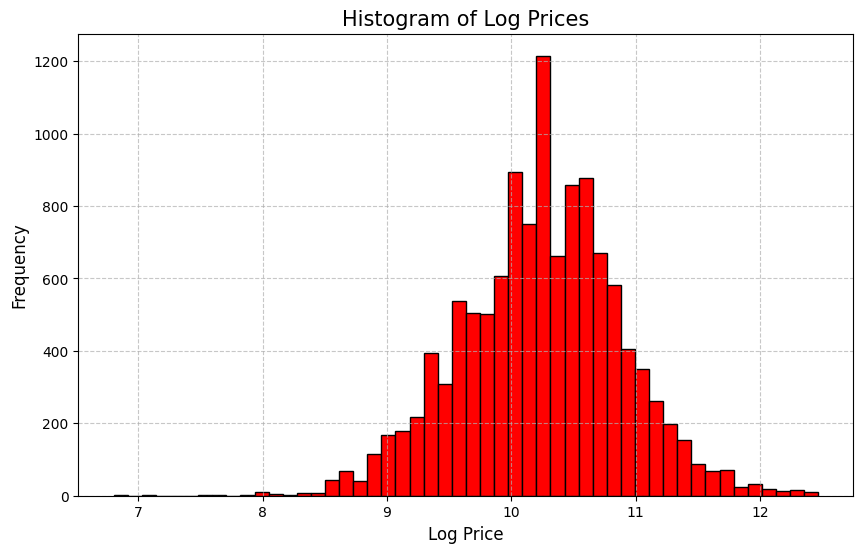

In [55]:
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=50, edgecolor='black', color='red')
plt.title('Histogram of Log Prices', fontsize=15)
plt.xlabel('Log Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

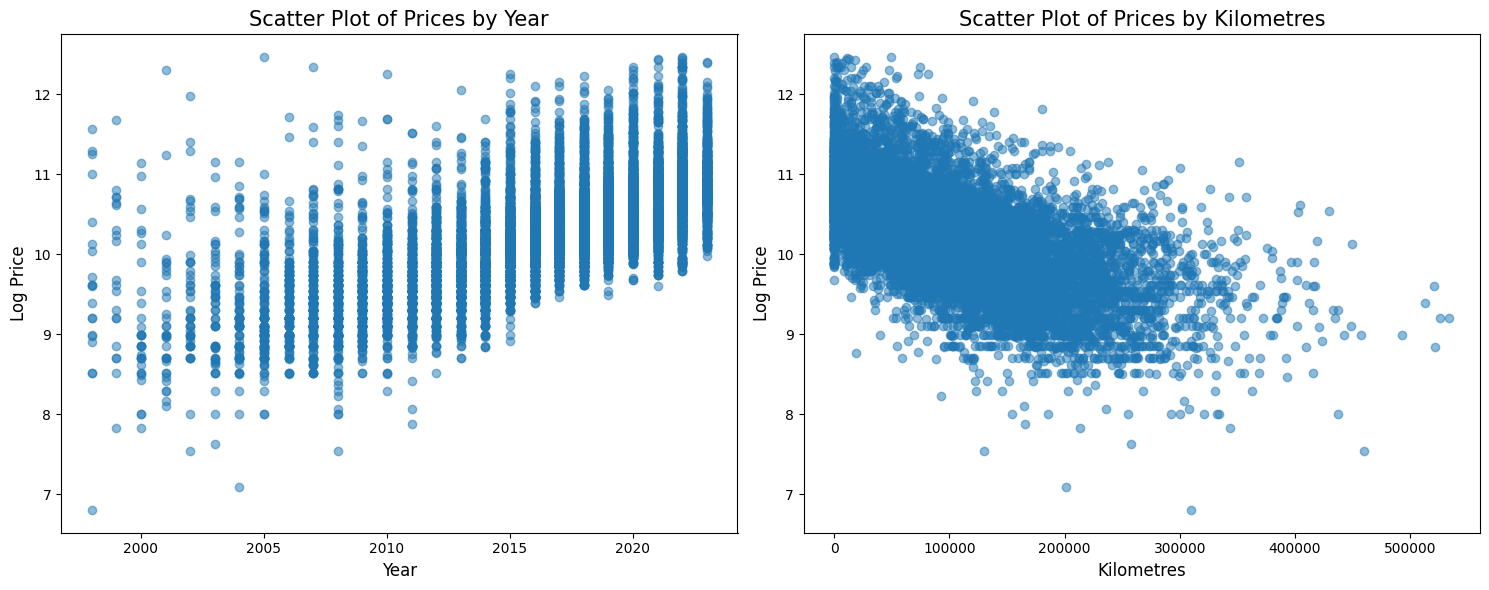

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# First subplot: Scatter Plot of Prices by Year
axs[0].scatter(X_train['Year'], y_train, alpha=0.5)
axs[0].set_title('Scatter Plot of Prices by Year', fontsize=15)
axs[0].set_xlabel('Year', fontsize=12)
axs[0].set_ylabel('Log Price', fontsize=12)

# Second subplot: Scatter Plot of Prices by Kilometres
axs[1].scatter(X_train['Kilometres'], y_train, alpha=0.5)
axs[1].set_title('Scatter Plot of Prices by Kilometres', fontsize=15)
axs[1].set_xlabel('Kilometres', fontsize=12)
axs[1].set_ylabel('Log Price', fontsize=12)

plt.tight_layout()

plt.savefig("scatterplots2.jpg")
plt.show()

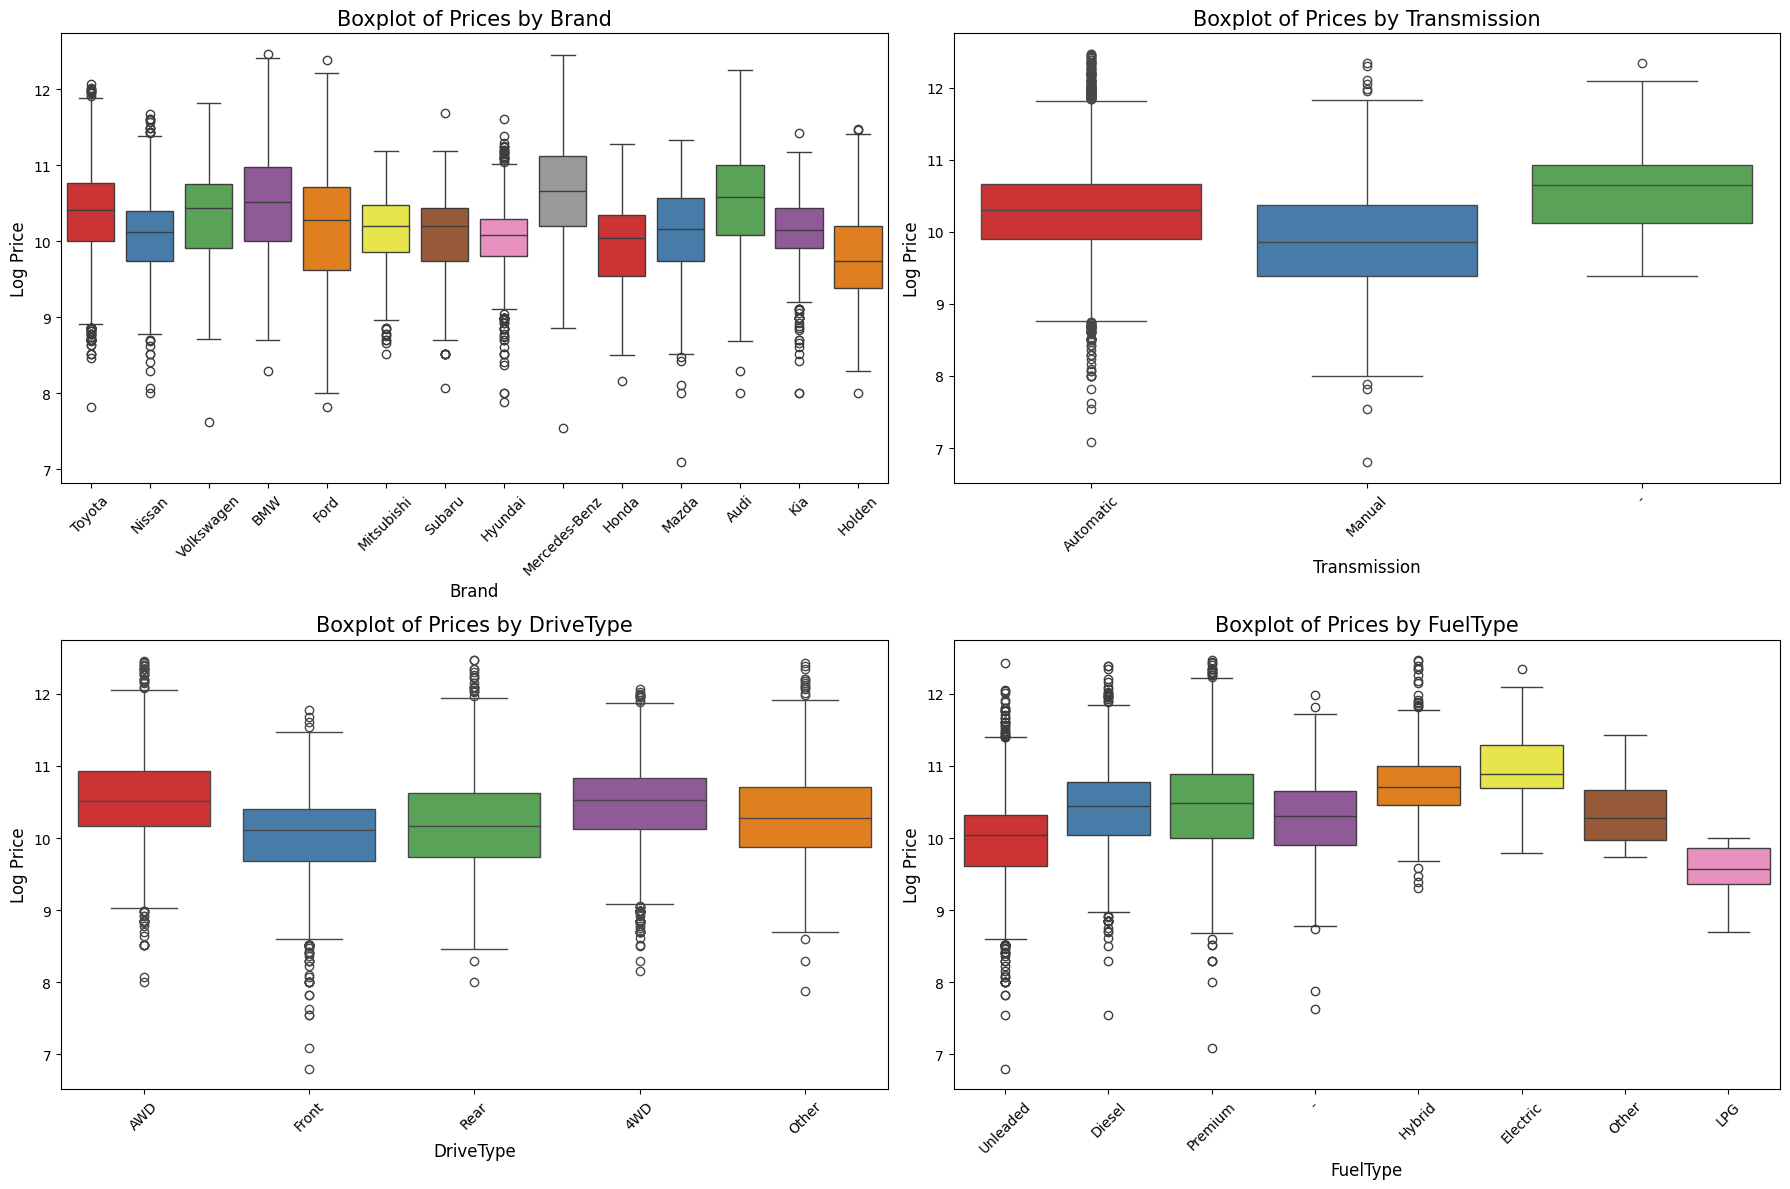

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

title_fontsize = 15
label_fontsize = 12

# First subplot: Boxplot of Prices by Brand (filtered by aggregated.index)
sns.boxplot(x='Brand', y=y_train, hue='Brand', data=X_train[X_train['Brand'].isin(aggregated.index)], ax=axes[0, 0], palette="Set1", dodge=False, legend=False)
axes[0, 0].set_title('Boxplot of Prices by Brand', fontsize=title_fontsize)
axes[0, 0].set_xlabel('Brand', fontsize=label_fontsize)
axes[0, 0].set_ylabel('Log Price', fontsize=label_fontsize)
axes[0, 0].tick_params(axis='x', rotation=45)


# Second subplot: Boxplot of Prices by Transmission
sns.boxplot(x='Transmission', y=y_train, hue='Transmission', data=X_train, ax=axes[0, 1], palette="Set1", dodge=False)
axes[0, 1].set_title('Boxplot of Prices by Transmission', fontsize=title_fontsize)
axes[0, 1].set_xlabel('Transmission', fontsize=label_fontsize)
axes[0, 1].set_ylabel('Log Price', fontsize=label_fontsize)
axes[0, 1].tick_params(axis='x', rotation=45)

# Third subplot: Boxplot of Prices by DriveType
sns.boxplot(x='DriveType', y=y_train, hue='DriveType', data=X_train, ax=axes[1, 0], palette="Set1", dodge=False)
axes[1, 0].set_title('Boxplot of Prices by DriveType', fontsize=title_fontsize)
axes[1, 0].set_xlabel('DriveType', fontsize=label_fontsize)
axes[1, 0].set_ylabel('Log Price', fontsize=label_fontsize)
axes[1, 0].tick_params(axis='x', rotation=45)

# Fourth subplot: Boxplot of Prices by FuelType
sns.boxplot(x='FuelType', y=y_train, hue='FuelType', data=X_train, ax=axes[1, 1], palette="Set1", dodge=False)
axes[1, 1].set_title('Boxplot of Prices by FuelType', fontsize=title_fontsize)
axes[1, 1].set_xlabel('FuelType', fontsize=label_fontsize)
axes[1, 1].set_ylabel('Log Price', fontsize=label_fontsize)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


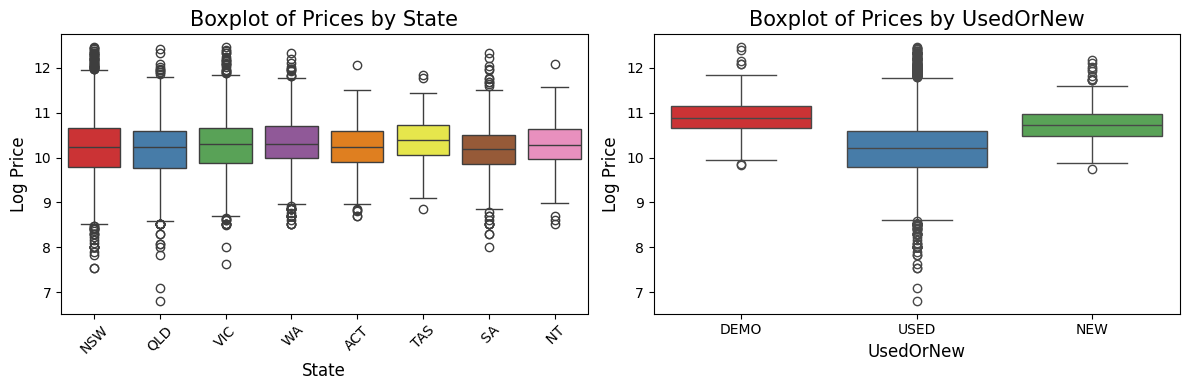

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# First subplot: Boxplot of Prices by State with color palette
sns.boxplot(x='State', y=y_train, hue='State', data=X_train, ax=axes[0], palette="Set1", dodge=False)
axes[0].set_title('Boxplot of Prices by State', fontsize=title_fontsize)
axes[0].set_xlabel('State', fontsize=label_fontsize)
axes[0].set_ylabel('Log Price', fontsize=label_fontsize)
axes[0].tick_params(axis='x', rotation=45)  # Rotate state labels if they overlap

# Second subplot: Boxplot of Prices by UsedOrNew with color palette
sns.boxplot(x='UsedOrNew', y=y_train, hue='UsedOrNew', data=X_train, ax=axes[1], palette="Set1", dodge=False)
axes[1].set_title('Boxplot of Prices by UsedOrNew', fontsize=title_fontsize)
axes[1].set_xlabel('UsedOrNew', fontsize=label_fontsize)
axes[1].set_ylabel('Log Price', fontsize=label_fontsize)

plt.tight_layout()

plt.savefig("boxplots2.jpg")
plt.show()

In [59]:
X_train.nunique()

Brand                   64
Year                    26
Model                  651
Title                 6832
UsedOrNew                3
Transmission             3
DriveType                5
FuelType                 8
FuelConsumption        144
Kilometres           10703
ColourExtInt           632
CylindersinEngine       10
BodyType                11
Doors                    5
Seats                   12
State                    8
Capacity                50
dtype: int64

In [60]:
X_train[['Brand',  'UsedOrNew', 'Transmission', 'DriveType', 'FuelType',
        'CylindersinEngine', 'BodyType', 'Doors', 'Seats',
        'State']].nunique()

Brand                64
UsedOrNew             3
Transmission          3
DriveType             5
FuelType              8
CylindersinEngine    10
BodyType             11
Doors                 5
Seats                12
State                 8
dtype: int64

In [61]:
X_train.shape, y_train.shape

((11936, 17), (11936,))

# Part 3 Script for Processing Test Sets

In [62]:
#Converting and Limiting the continous variables
X_test = X_test[X_test["Year"] > 1997]
y_test = y_test.loc[X_test.index]

y_test = y_test[y_test < percentile_price995]
X_test = X_test.loc[y_test.index]

X_test["Kilometres"] = pd.to_numeric(X_test["Kilometres"], errors='coerce')
X_test = X_test.dropna(subset=["Kilometres"])
y_test = y_test.loc[X_test.index]

In [63]:
# Replace identified categories and NaN values with 'missing_btc'
value_counts = X_test["Car/Suv"].value_counts()
categories_to_replace = value_counts[value_counts < 50].index.tolist()
X_test["Car/Suv"] = X_test["Car/Suv"].apply(lambda x: 'missing_btc' if pd.isna(x) or x in categories_to_replace else x)

mixed_missing_rows2 = X_test[(X_test["Car/Suv"] == 'missing_btc') & (X_test["BodyType"].isna())]
X_test = X_test.drop(mixed_missing_rows2.index)
y_test = y_test.drop(mixed_missing_rows2.index)

X_test = X_test.drop(columns=["Car/Suv"])
X_test["BodyType"] = X_test["BodyType"].fillna('missing_btc')

In [64]:
# Transform Location to State
X_test["State"] = X_test["Location"].str[-3:]
X_test = X_test.drop(columns=["Location"])
X_test["State"] = X_test["State"].fillna('missing_state')

In [65]:
# Check if "Doors" includes "Seats" and compare with "Seats" column
X_test["Includes_Seats"] = X_test["Doors"].str.contains("Seats")
X_test["Equal_to_Seats"] = X_test.apply(lambda row: row["Doors"] == row["Seats"] if row["Includes_Seats"] else None, axis=1)

X_test.loc[X_test["Includes_Seats"]==True, "Seats"] = X_test["Doors"]
X_test.loc[X_test["Includes_Seats"]==True, "Doors"] = "missing_dr"

X_test["Doors"] = X_test["Doors"].fillna('missing_dr')

X_test = X_test.drop(columns=["Includes_Seats", "Equal_to_Seats"])
X_test["Doors"] = X_test["Doors"].str.strip()

missingseats = X_test["Seats"].isna()
X_test["Seats"] = X_test["Seats"].fillna('missing_seats')

In [66]:
X_test['FuelConsumption'] = X_test['FuelConsumption'].apply(extract_number)

# Impute missing values and zeros with the median in X_test
X_test['FuelConsumption'] = X_test['FuelConsumption'].replace(0, np.nan)
X_test['FuelConsumption'] = X_test['FuelConsumption'].fillna(median_fuel_consumption)


In [67]:
# Apply the function to the 'Engine' column
X_test[['Cylinders', 'Capacity']] = X_test['Engine'].apply(lambda x: pd.Series(extract_engine_features(x)))

# Handle missing values (example: fill with median or mean)
X_test = X_test.drop(columns=['Cylinders']) #duplicated
median_capacity = X_test['Capacity'].median()
X_test['Capacity'] = X_test['Capacity'].fillna(median_capacity)
X_test = X_test.drop(columns=['Engine'])

In [68]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11936, 17), (11936,), (4013, 17), (4013,))

In [69]:
#Save the dataset for Neural Network

X_train_nn = X_train.copy().reset_index(drop=True)
X_test_nn = X_test.copy().reset_index(drop=True)
y_train_nn = y_train.copy().reset_index(drop=True)
y_test_nn = y_test.copy().reset_index(drop=True)

In [70]:
# # Assuming X_train, X_test, y_train, and y_test are pandas DataFrames or Series
# X_train.to_csv('X_train.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)


# Part 4 Baseline Model

## 3.1 Data Preprocessing

> These 3 columns contain extensive text information and are divided into numerous categories. Therefore, we have dropped them to build more robust tree-based models.

In [71]:
X_train_tree = X_train.drop(columns=["Model","Title","ColourExtInt"])
X_test_tree = X_test.drop(columns=["Model","Title","ColourExtInt"])

In [72]:
X_train_tree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11936 entries, 5354 to 7817
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              11936 non-null  object 
 1   Year               11936 non-null  int64  
 2   UsedOrNew          11936 non-null  object 
 3   Transmission       11936 non-null  object 
 4   DriveType          11936 non-null  object 
 5   FuelType           11936 non-null  object 
 6   FuelConsumption    11936 non-null  float64
 7   Kilometres         11936 non-null  float64
 8   CylindersinEngine  11936 non-null  object 
 9   BodyType           11936 non-null  object 
 10  Doors              11936 non-null  object 
 11  Seats              11936 non-null  object 
 12  State              11936 non-null  object 
 13  Capacity           11936 non-null  float64
dtypes: float64(3), int64(1), object(10)
memory usage: 1.6+ MB


In [73]:
columns_to_encode = ['Brand', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 
                      'BodyType', 'Doors', 'Seats', 'State']

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # Use drop='first' to handle multicollinearity in linear models
encoded_data = ohe.fit_transform(X_train_tree[columns_to_encode])

# Create a DataFrame with the encoded data
encoded_columns = ohe.get_feature_names_out(columns_to_encode)
df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns, index=X_train_tree.index)
cleaned_tree_df = pd.concat([X_train_tree.drop(columns_to_encode, axis=1), df_encoded], axis=1)

# Ordinal encode 'CylindersinEngine'
ordinal_encoder = OrdinalEncoder()
ordinal_encoded_data = ordinal_encoder.fit_transform(X_train_tree[['CylindersinEngine']])
df_ordinal_encoded = pd.DataFrame(ordinal_encoded_data, columns=['CylindersinEngine_Ordinal'], index=X_train_tree.index)

cleaned_tree_df = pd.concat([X_train_tree.drop(columns_to_encode + ['CylindersinEngine'], axis=1), df_ordinal_encoded, df_encoded], axis=1)
cleaned_tree_df.head()


,Year,FuelConsumption,Kilometres,Capacity,CylindersinEngine_Ordinal,Brand_Alfa,Brand_Aston,Brand_Audi,Brand_BMW,Brand_BYD,...,Seats_ 8 Seats,Seats_ 9 Seats,Seats_missing_seats,State_ SA,State_ WA,State_ACT,State_NSW,State_QLD,State_TAS,State_VIC
5354,2022,7.5,996.0,2.5,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9601,2016,8.4,168034.0,2.5,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11017,2020,7.5,33243.0,2.8,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
605,2019,6.0,97327.0,1.4,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10528,2011,12.6,329000.0,2.7,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [74]:
# Transform X_test using the fitted OneHotEncoder
encoded_data_test = ohe.transform(X_test_tree[columns_to_encode])
df_encoded_test = pd.DataFrame(encoded_data_test, columns=encoded_columns, index=X_test_tree.index)
cleaned_tree_df_test = pd.concat([X_test_tree.drop(columns_to_encode, axis=1), df_encoded_test], axis=1)

ordinal_encoded_data_test = ordinal_encoder.transform(X_test_tree[['CylindersinEngine']])
df_ordinal_encoded_test = pd.DataFrame(ordinal_encoded_data_test, columns=['CylindersinEngine_Ordinal'], index=X_test_tree.index)
cleaned_tree_df_test = pd.concat([X_test_tree.drop(columns_to_encode + ['CylindersinEngine'], axis=1), df_ordinal_encoded_test, df_encoded_test], axis=1)

cleaned_tree_df_test.head()

/Users/keithtang/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Year,FuelConsumption,Kilometres,Capacity,CylindersinEngine_Ordinal,Brand_Alfa,Brand_Aston,Brand_Audi,Brand_BMW,Brand_BYD,...,Seats_ 8 Seats,Seats_ 9 Seats,Seats_missing_seats,State_ SA,State_ WA,State_ACT,State_NSW,State_QLD,State_TAS,State_VIC
9457,2020.0,6.8,35612.0,1.6,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11075,2018.0,8.5,144727.0,3.2,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7232,2022.0,13.0,21786.0,5.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
201,2022.0,5.2,11824.0,1.5,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3919,2022.0,5.4,29678.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 3.2 Decision Tree Model

In [75]:
model_tree = DecisionTreeRegressor(random_state=2024)
model_tree.fit(cleaned_tree_df, y_train)
y_pred_tr = np.exp(model_tree.predict(cleaned_tree_df_test))

In [76]:
mae_tr = mean_absolute_error(y_test, y_pred_tr)
rmse_tr = np.sqrt(mean_squared_error(y_test, y_pred_tr))
r2_tr = r2_score(y_test, y_pred_tr)

print(f"Tree MAE: {mae_tr:.2f}")
print(f"Tree RMSE: {rmse_tr:.2f}")
print(f"Tree R: {r2_tr:.4f}")

Tree MAE: 6469.97
Tree RMSE: 12697.27
Tree R: 0.7102


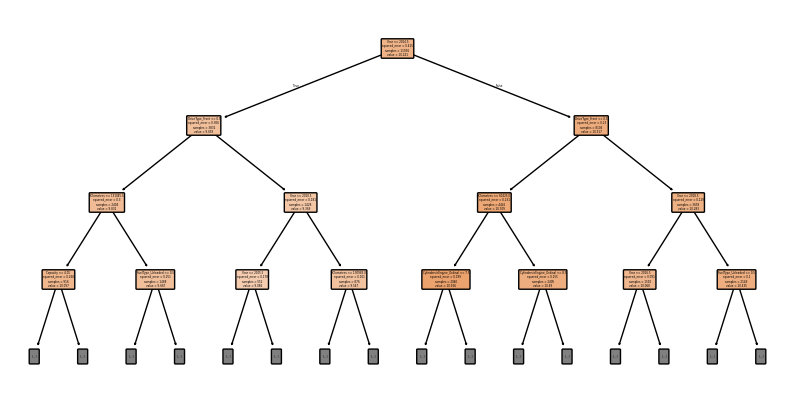

In [77]:
plt.figure(figsize=(10, 5))
plot_tree(model_tree, feature_names=cleaned_tree_df.columns, filled=True, rounded=True, max_depth=3)
plt.show()

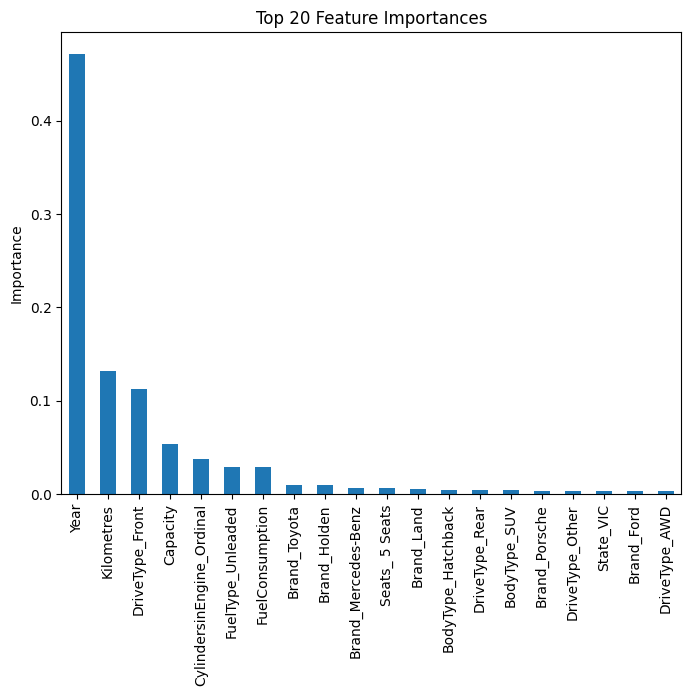

In [78]:
importances = model_tree.feature_importances_
forest_importances = pd.Series(importances, index=cleaned_tree_df.columns).sort_values(ascending=False)
top_20_importances = forest_importances.head(20)

# Plot the top 20 feature importances

fig, ax = plt.subplots(figsize=(8, 6))
top_20_importances.plot.bar(ax=ax)
ax.set_title("Top 20 Feature Importances")
ax.set_ylabel("Importance")
plt.show()


In [79]:
tree_para = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50],
             'min_samples_leaf': [2,3,4,5,6,7,8,9, 10, 15, 20, 50]}

scoring = {
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Initialize the DecisionTreeRegressor
tuned_decision_tree = DecisionTreeRegressor(random_state=2024)

# Initialize GridSearchCV with refit='mse'
tuned_model_tree = GridSearchCV(
    estimator=tuned_decision_tree,
    param_grid=tree_para,
    scoring=scoring,
    cv=5,
    refit='mse'  # Refit the model using the best parameter combination for 'mse'
)

In [80]:
# Fit the model
start_time = time.time()
tuned_model_tree.fit(cleaned_tree_df, y_train)
end_time = time.time()
fitting_time = end_time - start_time

print(f"Time taken to fit the model: {fitting_time:.2f} seconds")

Time taken to fit the model: 43.17 seconds


/Users/keithtang/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [81]:
best_params_tr = tuned_model_tree.best_params_
best_score_tr = tuned_model_tree.best_score_

print(f"Best parameters: {best_params_tr}")
# Predict using the best estimator
y_pred_trtone = np.exp(tuned_model_tree.best_estimator_.predict(cleaned_tree_df_test))


mae_trtone = mean_absolute_error(y_test, y_pred_trtone)
rmse_trtone = np.sqrt(mean_squared_error(y_test, y_pred_trtone))
r2_trtone = r2_score(y_test, y_pred_trtone)

print(f"Tuned Tree MAE: {mae_trtone:.2f}")
print(f"Tuned Tree RMSE: {rmse_trtone:.2f}")
print(f"Tuned Tree R2: {r2_trtone:.4f}")


Best parameters: {'max_depth': 12, 'min_samples_leaf': 5}
Tuned Tree MAE: 6438.70
Tuned Tree RMSE: 12079.35
Tuned Tree R2: 0.7377


## 3.3 Random Forest

In [82]:
rf_regressor = RandomForestRegressor(random_state=2024, max_features='sqrt')
rf_regressor.fit(cleaned_tree_df, y_train)
y_pred_rf = np.exp(rf_regressor.predict(cleaned_tree_df_test))

# Calculate metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R2: {r2_rf:.4}")

#print(rf_regressor.get_params())

Random Forest MAE: 4598.000161219278
Random Forest RMSE: 9989.835629867894
Random Forest R2: 0.8206


/Users/keithtang/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [83]:
# Create the parameter grid
cv_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10,50,None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 1],
    'bootstrap': [True],
    'criterion': ['squared_error']
}

# Instantiate the RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=2024)
kf = KFold(n_splits=3, shuffle=True, random_state=2024)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=cv_params,
    cv=kf,
    scoring='neg_mean_absolute_error',  # You can choose other metrics based on your need
    verbose=0,
    n_jobs=-1
)

# Fit the GridSearchCV

start_time = time.time()
grid_search.fit(cleaned_tree_df, y_train)
end_time = time.time()
fitting_time = end_time - start_time
print(f"Time taken to fit the model: {fitting_time:.2f} seconds")

Time taken to fit the model: 35.35 seconds


In [84]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
best_model = grid_search.best_estimator_

Best parameters found:  {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [85]:
y_pred_rttone = np.exp(best_model.predict(cleaned_tree_df_test))

# Calculate metrics
mae_rftone = mean_absolute_error(y_test, y_pred_rttone)
mse_rftone = mean_squared_error(y_test, y_pred_rttone)
rmse_rftone = mean_squared_error(y_test, y_pred_rttone, squared=False)
r2_rftone = r2_score(y_test, y_pred_rttone)

print(f"Tuned Random Forest MAE: {mae_rftone}")
print(f"Tuned Random Forest RMSE: {rmse_rftone}")
print(f"Tuned Random Forest R2: {r2_rftone}")

Tuned Random Forest MAE: 4590.193109951453
Tuned Random Forest RMSE: 9907.986276325735
Tuned Random Forest R2: 0.8235100426757189


/Users/keithtang/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 3.4 Gradient Boosting

In [86]:
gbm_regressor = GradientBoostingRegressor(random_state=2024)
gbm_regressor.fit(cleaned_tree_df, y_train)
y_pred_gbm = np.exp(gbm_regressor.predict(cleaned_tree_df_test))

# Calculate metrics
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
rmse_gbm = mean_squared_error(y_test, y_pred_gbm, squared=False)
r2_gbm = r2_score(y_test, y_pred_gbm)

print(f"Gradient Boosting MAE: {mae_gbm}")
print(f"Gradient Boosting RMSE: {rmse_gbm}")
print(f"Gradient Boosting R2: {r2_gbm:.4}")

Gradient Boosting MAE: 5947.178675023168
Gradient Boosting RMSE: 11041.392992712868
Gradient Boosting R2: 0.7808


/Users/keithtang/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [87]:
# Create the parameter grid for GradientBoostingRegressor
cv_params_gbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt']
}

# Instantiate the GradientBoostingRegressor
gbm_regressor = GradientBoostingRegressor(random_state=2024)
kf = KFold(n_splits=3, shuffle=True, random_state=2024)

# Perform GridSearchCV
grid_search_gbm = GridSearchCV(
    estimator=gbm_regressor,
    param_grid=cv_params_gbm,
    cv=kf,
    scoring='neg_mean_absolute_error',  # You can choose other metrics based on your need
    verbose=0,
    n_jobs=-1
)

# Fit the GridSearchCV
start_time = time.time()
grid_search_gbm.fit(cleaned_tree_df, y_train)
end_time = time.time()
fitting_time = end_time - start_time
print(f"Time taken to fit the model: {fitting_time:.2f} seconds")

# Get the best estimator and its parameters
best_gbm = grid_search_gbm.best_estimator_
best_params = grid_search_gbm.best_params_

print(f"Best parameters: {best_params}")

# Make predictions with the best estimator
y_pred_gbm_best = np.exp(best_gbm.predict(cleaned_tree_df_test))

# Calculate metrics
mae_gbm_best = mean_absolute_error(y_test, y_pred_gbm_best)
mse_gbm_best = mean_squared_error(y_test, y_pred_gbm_best)
rmse_gbm_best = mean_squared_error(y_test, y_pred_gbm_best, squared=False)
r2_gbm_best = r2_score(y_test, y_pred_gbm_best)

print(f"Best Gradient Boosting MAE: {mae_gbm_best}")
print(f"Best Gradient Boosting RMSE: {rmse_gbm_best}")
print(f"Best Gradient Boosting R2: {r2_gbm_best:.4}")

Time taken to fit the model: 33.12 seconds
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Gradient Boosting MAE: 4252.920544945497
Best Gradient Boosting RMSE: 8674.344666633
Best Gradient Boosting R2: 0.8647


/Users/keithtang/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


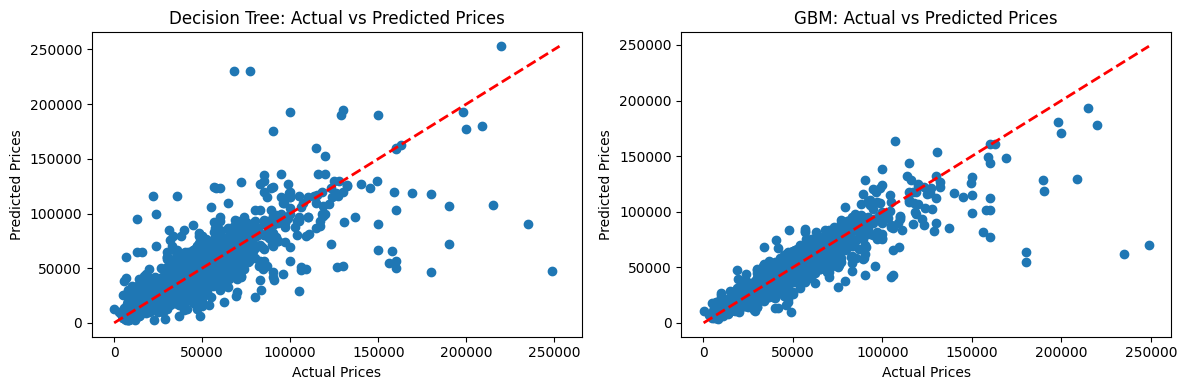

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Decision Tree: Actual vs Predicted Prices
axes[0].scatter(y_test, y_pred_tr)
axes[0].set_xlabel('Actual Prices')
axes[0].set_ylabel('Predicted Prices')
axes[0].set_title('Decision Tree: Actual vs Predicted Prices')
min_val = min(min(y_test), min(y_pred_tr))
max_val = max(max(y_test), max(y_pred_tr))
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

# GBM: Actual vs Predicted Prices
axes[1].scatter(y_test, y_pred_gbm_best)
axes[1].set_xlabel('Actual Prices')
axes[1].set_ylabel('Predicted Prices')
axes[1].set_title('GBM: Actual vs Predicted Prices')
min_val = min(min(y_test), min(y_pred_gbm_best))
max_val = max(max(y_test), max(y_pred_gbm_best))
axes[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)


plt.tight_layout()

plt.savefig("GBMfit.jpg")
plt.show()


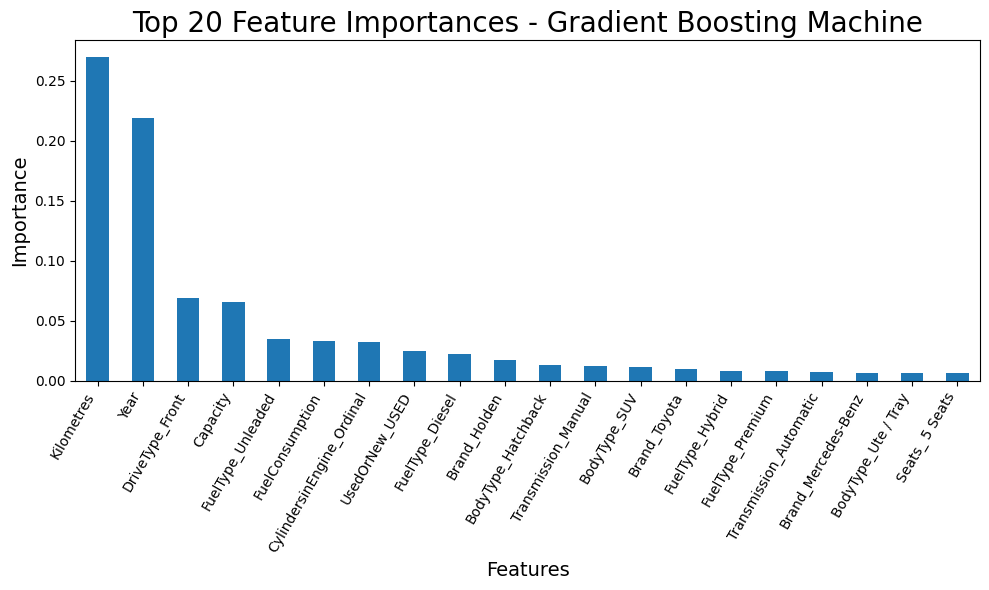

In [89]:
gbm_importances = best_gbm.feature_importances_
gbm_forest_importances = pd.Series(gbm_importances, index=cleaned_tree_df.columns).sort_values(ascending=False)
top_20_gbm_importances = gbm_forest_importances.head(20)

# Plot the top 20 feature importances for the GBM model
fig, ax = plt.subplots(figsize=(10, 6))
top_20_gbm_importances.plot.bar(ax=ax)
ax.set_title("Top 20 Feature Importances - Gradient Boosting Machine", fontsize=20)  # Increase title size
ax.set_ylabel("Importance", fontsize=14)
ax.set_xlabel("Features", fontsize=14)
ax.set_xticklabels(top_20_gbm_importances.index, rotation=60, ha='right', fontsize=10)  # Increase rotation angle and label size

plt.tight_layout()

plt.savefig("GBM_importances.jpg")
plt.show()

## 3.5 Baseline Model Selection

In [90]:
baseline = {
    'Model': ['Decision Tree', 'Tuned Decision Tree', 'Random Forest', 'Tuned Random Forest', 'Gradient Boosting', 'Tuned Gradient Boosting'],
    'MAE': [mae_tr, mae_trtone, mae_rf, mae_rftone, mae_gbm, mae_gbm_best],
    'RMSE': [rmse_tr, rmse_trtone, rmse_rf, rmse_rftone, rmse_gbm, rmse_gbm_best],
    'R2': [r2_tr, r2_trtone, r2_rf, r2_rftone, r2_gbm, r2_gbm_best]
}

# Create the DataFrame
metrics_df = pd.DataFrame(baseline)
metrics_df['MAE'] = metrics_df['MAE'].map(lambda x: f"{x:.2f}")
metrics_df['RMSE'] = metrics_df['RMSE'].map(lambda x: f"{x:.2f}")
metrics_df['R2'] = metrics_df['R2'].map(lambda x: f"{x:.4f}")

print(metrics_df)

                     Model      MAE      RMSE      R2
0            Decision Tree  6469.97  12697.27  0.7102
1      Tuned Decision Tree  6438.70  12079.35  0.7377
2            Random Forest  4598.00   9989.84  0.8206
3      Tuned Random Forest  4590.19   9907.99  0.8235
4        Gradient Boosting  5947.18  11041.39  0.7808
5  Tuned Gradient Boosting  4252.92   8674.34  0.8647


> Eventually, we chose the Tuned Gradient Boosting model with a root mean square error of 8674 and an R-squared value of 0.8647 as our baseline model.

In [91]:
metrics_df.to_csv('metrics_df.csv', index=False)
print("DataFrame saved to 'metrics_df.csv'")

DataFrame saved to 'metrics_df.csv'


# Part 5 NN-Model 1: Dense Sequential

## M1.1 Data Preprocessing

In [92]:
# X_train_M1 = pd.read_csv('X_train.csv')
# X_test_M1 = pd.read_csv('X_test.csv')
# y_train_M1 = pd.read_csv('y_train.csv')
# y_test_M1 = pd.read_csv('y_test.csv')

In [93]:
X_train_M1 = X_train_nn.copy()
X_test_M1 = X_test_nn.copy()
y_train_M1 = pd.DataFrame(y_train_nn.copy())
y_test_M1 = pd.DataFrame(y_test_nn.copy())

In [94]:
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Split the training data into training and validation sets
X_train_M1, X_val_M1, y_train_M1, y_val_M1 = train_test_split(X_train_M1, y_train_M1, test_size=0.2, random_state=2024)


In [95]:
y_train_M1 = y_train_M1.to_numpy()
y_val_M1 = y_val_M1.to_numpy()
y_test_M1 = y_test_M1.to_numpy()

In [96]:
X_train_M1 = X_train_M1.drop(columns=["Model","Title","ColourExtInt"]) #Drop the text columns
X_val_M1 = X_val_M1.drop(columns=["Model","Title","ColourExtInt"])
X_test_M1 = X_test_M1.drop(columns=["Model","Title","ColourExtInt"])

In [97]:
X_train_M1.columns

Index(['Brand', 'Year', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType',
       'FuelConsumption', 'Kilometres', 'CylindersinEngine', 'BodyType',
       'Doors', 'Seats', 'State', 'Capacity'],
      dtype='object')

In [98]:
# Define categorical and ordinal variables
cat_vars = ['Brand', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 
                      'BodyType', 'Doors', 'Seats', 'State']
ordinal_vars = ["CylindersinEngine"]

# Define the column transformer
ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_vars),
    (OrdinalEncoder(), ordinal_vars),
    remainder=StandardScaler(),  # Apply StandardScaler() to the remaining columns
    verbose_feature_names_out=False
)

# Apply the column transformer to the data
X_train_ct_M1 = ct.fit_transform(X_train_M1)
X_val_ct_M1 =ct.transform(X_val_M1)
X_test_ct_M1 =ct.transform(X_test_M1)

## M1.2 Model Construction

In [99]:
def create_modelR(seed=2024):
    random.seed(seed)
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Input(X_train_ct_M1.shape[1:]))
    model.add(Dense(32, "leaky_relu"))
    model.add(Dense(16, "leaky_relu"))
    model.add(Dense(1, activation='relu'))  

    return model


In [100]:
model_regress = create_modelR()
model_regress.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
model_regress.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time_fit = time.time()
history_regress = model_regress.fit(X_train_ct_M1,y_train_M1, epochs=200, verbose=0, callbacks=[early_stopping], validation_data=(X_val_ct_M1, y_val_M1)
          );

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

Model fitting time: 7.738322734832764 seconds


In [102]:
# Predict on the test data
log_yr_pred_M1 = model_regress.predict(X_test_ct_M1, verbose=0)

# Apply the exponential function to the predictions to revert to the original scale
yr_pred_M1 = np.exp(log_yr_pred_M1)

# Evaluate the model on the test data by calculating RMSE and MAE manually
test_rmse_M1 = np.sqrt(np.mean((yr_pred_M1 - y_test_M1)**2))
test_mae_M1 = np.mean(np.abs(yr_pred_M1 - y_test_M1))

# Create a dictionary with the results
results = {
    'RMSE': [round(test_rmse_M1, 2)],
    'MAE': [round(test_mae_M1, 2)],
    'Number of Samples': [len(y_test_M1)]
}

results_M1 = pd.DataFrame(results)
results_M1

,RMSE,MAE,Number of Samples
0,10192.65,5092.08,4013


## M1.3 Hyperparameter Tuning

### M1.3.1 Dropout Experiment

In [104]:
def create_modelRDO(seed=2024):
    random.seed(seed)
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Input(X_train_ct_M1.shape[1:]))
    model.add(Dense(32, "leaky_relu"))
    model.add(Dropout(0.05))
    model.add(Dense(16, "leaky_relu"))
    model.add(Dense(1, activation='relu'))  

    return model

In [105]:
model_regress2 = create_modelRDO()
model_regress2.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time_fit = time.time()
history_regress2 = model_regress2.fit(X_train_ct_M1,y_train_M1, epochs=200, verbose=0, callbacks=[early_stopping], validation_data=(X_val_ct_M1, y_val_M1)
          );

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

Model fitting time: 3.1890828609466553 seconds


In [106]:
# Predict on the test data
log_yr_pred_M1 = model_regress2.predict(X_test_ct_M1, verbose=0)

# Apply the exponential function to the predictions to revert to the original scale
yr_pred_M1 = np.exp(log_yr_pred_M1)

# Evaluate the model on the test data by calculating RMSE and MAE manually
test_rmse = np.sqrt(np.mean((yr_pred_M1 - y_test_M1)**2))
test_mae = np.mean(np.abs(yr_pred_M1 - y_test_M1))

# Create a dictionary with the results
results = {
    'RMSE': [round(test_rmse, 2)],
    'MAE': [round(test_mae, 2)],
    'Number of Samples': [len(y_test_M1)]
}

# Convert the dictionary to a DataFrame
results_M1_DO = pd.DataFrame(results)
results_M1_DO

,RMSE,MAE,Number of Samples
0,12108.48,6438.21,4013


### M1.3.2 Grid Search for number of layers, number of neurons, batch sizes and learning rates

In [107]:
def create_model(seed, num_layers, num_neurons, activation, learning_rate, input_shape):
    random.seed(seed)
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    for _ in range(num_layers):
        model.add(Dense(num_neurons, activation=activation))
    model.add(Dense(16, "leaky_relu"))
    model.add(Dense(1, activation='relu'))  # Output layer for regression
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [108]:
# Experimentation setup
activations = ['leaky_relu']
layers = [1,2,3]
neurons = [8,16,32,64]
batch_sizes = [32, 64]
learning_rates = [0.001, 0.005, 0.01]

results = []

for activation in activations:
    for layer in layers:
        for neuron in neurons:
            for batch_size in batch_sizes:
                for learning_rate in learning_rates:
                    # Create the model
                    model = create_model(2024, num_layers=layer, num_neurons=neuron, activation=activation, learning_rate=learning_rate, input_shape=X_train_ct_M1.shape[1])

                    # Set up early stopping
                    es = EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss", verbose=0)

                    # Fit the model
                    start_time = time.time()
                    hist = model.fit(X_train_ct_M1, y_train_M1, batch_size=batch_size, callbacks=[es], epochs=200, verbose=0, validation_data=(X_val_ct_M1, y_val_M1))
                    end_time = time.time()
                    fit_time = end_time - start_time

                    # Evaluate the model
                    # eval_results = model.evaluate(X_val_ct, y_val, verbose=0)
                    # eval_results_test = model.evaluate(X_test_ct, y_test, verbose=0)

                    # Predict on the test set
                    y_pred_M1 = model.predict(X_test_ct_M1, verbose=0)
                    y_pred_M1 = np.exp(y_pred_M1)  # Apply exponential if the targets were log-transformed

                    # Calculate additional metrics
                    rmse = np.sqrt(mean_squared_error(y_test_M1, y_pred_M1))
                    mae = mean_absolute_error(y_test_M1, y_pred_M1)
                    # Get the number of epochs from the history
                    num_epochs = len(hist.history['loss'])

                    # Store the results
                    results.append({
                        'activation': activation,
                        'layers': layer,
                        'neurons': neuron,
                        'batch_size': batch_size,
                        'learning_rate': learning_rate,
                        'epochs': num_epochs,
                        'rmse': rmse,
                        'mae': mae,
                        'fit_time': fit_time
                    })

In [109]:
results_M1_GS = pd.DataFrame(results)
results_M1_GS = results_M1_GS.round(4)
results_M1_GS

,activation,layers,neurons,batch_size,learning_rate,epochs,rmse,mae,fit_time
0,leaky_relu,1,8,32,0.001,200,10753.0899,5504.4945,17.4854
1,leaky_relu,1,8,32,0.005,170,10161.4720,5198.6513,14.7548
2,leaky_relu,1,8,32,0.010,72,10899.4116,5645.4472,6.5082
3,leaky_relu,1,8,64,0.001,200,10882.9882,5777.5783,10.3263
4,leaky_relu,1,8,64,0.005,139,10549.6416,5363.8634,7.2695
...,...,...,...,...,...,...,...,...,...
67,leaky_relu,3,64,32,0.005,50,10720.3185,5687.9071,6.2320
68,leaky_relu,3,64,32,0.010,57,10101.2543,5215.0735,7.0345
69,leaky_relu,3,64,64,0.001,74,9762.2394,5024.2953,5.7786
70,leaky_relu,3,64,64,0.005,77,9708.4146,5137.0084,6.0356


### M1.3.3 Optimised Result

In [110]:
results_M1_GS[results_M1_GS['rmse']==min(results_M1_GS['rmse'])]

,activation,layers,neurons,batch_size,learning_rate,epochs,rmse,mae,fit_time
39,leaky_relu,2,32,64,0.001,114,9641.6418,5021.5198,6.8535


# Part 6 NN-Model 2: Embedding Layer for Extracting Text in `Title`

## M2.1 Data Preprocessing

In [111]:
# Set random seeds for reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

X_train_M2 = X_train_nn.copy()
X_test_M2 = X_test_nn.copy()
y_train_M2 = pd.DataFrame(y_train_nn.copy())
y_test_M2 = pd.DataFrame(y_test_nn.copy())

In [112]:
# # Load the data
# X_train_M2 = pd.read_csv('X_train.csv')
# X_test_M2 = pd.read_csv('X_test.csv')
# y_train_M2 = pd.read_csv('y_train.csv')
# y_test_M2 = pd.read_csv('y_test.csv')

In [113]:
# Split the training data into new training set and validation set before processing
X_train_M2, X_val_M2, y_train_M2, y_val_M2 = train_test_split(
    X_train_M2, y_train_M2, test_size=0.2, random_state=seed)

In [114]:
X_train_M2 = X_train_M2.reset_index(drop=True)
X_val_M2 = X_val_M2.reset_index(drop=True)
y_train_M2 = y_train_M2.reset_index(drop=True)
y_val_M2 = y_val_M2.reset_index(drop=True)

In [115]:
y_train_M2 = y_train_M2.to_numpy()
y_val_M2 = y_val_M2.to_numpy()
y_test_M2 = y_test_M2.to_numpy()

In [116]:
X_train_M2[['Model','ColourExtInt','Title']].nunique()

Model            613
ColourExtInt     535
Title           5911
dtype: int64

In [117]:
X_train_M2[['Model','ColourExtInt','Title']].head(5)

,Model,ColourExtInt,Title
0,UTE,Green / -,2012 Holden UTE SV6
1,G10,White / -,2021 LDV G10 Barn Door
2,Tiguan,White / -,2018 Volkswagen Tiguan 162 TSI Highline
3,Rover,Black / -,2018 Land Rover Range Rover Velar D300 R-Dynam...
4,Lancer,Grey / -,2010 Mitsubishi Lancer CJ ES Sport Sedan 4dr C...


In [118]:
# Prepare the combined text column for embedding in training, validation, and test sets
# Tested combined_text with 'Model' and/or'ColourExtInt' column but the RMSE increased and therefore only using 'Title' here

X_train_M2['combined_text'] = X_train_M2[['Title']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
X_val_M2['combined_text'] = X_val_M2[['Title']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
X_test_M2['combined_text'] = X_test_M2[['Title']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Initialize and fit the tokenizer on the training set
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_M2['combined_text'])

In [119]:
# Initialize and fit the tokenizer on the training set
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_M2['combined_text'])

# Convert text to sequences for all sets
X_train_sequences = tokenizer.texts_to_sequences(X_train_M2['combined_text'])
X_val_sequences = tokenizer.texts_to_sequences(X_val_M2['combined_text'])
X_test_sequences = tokenizer.texts_to_sequences(X_test_M2['combined_text'])

In [120]:
# Pad sequences to ensure uniform length
max_sequence_length = max([len(seq) for seq in X_train_sequences])  # max_sequence_length=17
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_sequences, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=max_sequence_length)

In [121]:
# Prepare embedding matrix if using pre-trained embeddings
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_dim = 7 # vocab = 1773 => the fourth square root of 1773 is 6.48. I tried 6, 7 and 8,  finding that 7 has a much lower RMSE

# Initialize embedding matrix with random values
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

In [122]:
vocab_size

1773

In [123]:
# Define categorical and ordinal variables
cat_vars = ['Brand', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 
            'BodyType', 'Doors', 'Seats', 'State']
ordinal_vars = ["CylindersinEngine"]

# Create a pipeline for numerical columns with imputation and scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())
])

# Apply column transformer to the combined data
ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_vars),
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_vars),
    (num_pipeline, list(set(X_train_M2.columns) - set(cat_vars) - set(ordinal_vars) - {'Model', 'Title', 'ColourExtInt', 'combined_text'})),
    verbose_feature_names_out=False
)

# Combine the padded text sequences with the original structured data
X_train_combined = pd.concat([X_train_M2.drop(columns=['Model', 'Title', 'ColourExtInt', 'combined_text']), pd.DataFrame(X_train_padded)], axis=1)
X_val_combined = pd.concat([X_val_M2.drop(columns=['Model', 'Title', 'ColourExtInt', 'combined_text']), pd.DataFrame(X_val_padded)], axis=1)
X_test_combined = pd.concat([X_test_M2.drop(columns=['Model', 'Title', 'ColourExtInt', 'combined_text']), pd.DataFrame(X_test_padded)], axis=1)

# Ensure all column names are strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_val_combined.columns = X_val_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Apply the column transformer to the data
X_train_M2_ct = ct.fit_transform(X_train_combined)
X_val_M2_ct = ct.transform(X_val_combined)
X_test_M2_ct = ct.transform(X_test_combined)

In [124]:
X_train_M2_ct.shape, X_train_padded.shape, X_val_M2_ct.shape,X_val_padded.shape, 

((9548, 123), (9548, 17), (2388, 123), (2388, 17))

## M2.2 Model Construction

In [125]:
# Define the combined model
def create_combined_model(seed=2024):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)
    # Define input layers
    structured_input = Input(shape=(X_train_M2_ct.shape[1],))
    text_input = Input(shape=(max_sequence_length,))
    
    # Define the text embedding layer
    text_embedding = embedding_layer(text_input)
    text_flatten = Flatten()(text_embedding)

    # Concatenate structured and text features
    combined = Concatenate()([structured_input, text_flatten])

    # Add dense layers
    x = Dense(128, activation='leaky_relu')(combined)
    x = Dense(128, activation='leaky_relu')(x)
    x = Dense(32, activation='leaky_relu')(x)
    output = Dense(1, activation='relu')(x)

    # Create and compile the model
    optimizer = Adam(learning_rate=0.0005)
    model = Model(inputs=[structured_input, text_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Create and summarize the model
model_combined = create_combined_model()
model_combined.summary()

Model: "functional_295"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_75      │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 17, 7)     │     12,411 │ input_layer_75[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_74      │ (None, 123)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 119)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 242)       │          0 │ input_layer_74[0… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_294 (Dense)   │ (None, 128)       │     31,104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_295 (Dense)   │ (None, 128)       │     16,512 │ dense_294[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_296 (Dense)   │ (None, 32)        │      4,128 │ dense_295[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_297 (Dense)   │ (None, 1)         │         33 │ dense_296[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,188 (250.73 KB)

 Trainable params: 64,188 (250.73 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
#plot_model(model_combined, to_file='combined_model.png', show_shapes=True, show_layer_names=True)  #Plot the Network Architecture

In [127]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time_fit = time.time()
history_combined = model_combined.fit(
    [X_train_M2_ct, X_train_padded], y_train_M2,
    validation_data=([X_val_M2_ct, X_val_padded], y_val_M2),
    callbacks=[early_stopping], 
    epochs=200,  
    verbose=0
)

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

# Predict on the test data
log_yr_pred_M2 = model_combined.predict([X_test_M2_ct, X_test_padded], verbose=0)
yr_pred_M2 = np.exp(log_yr_pred_M2)

# Evaluate the model on the test data by calculating RMSE and MAE manually
test_rmse_M2 = np.sqrt(np.mean((yr_pred_M2 - y_test_M2)**2))
test_mae_M2 = np.mean(np.abs(yr_pred_M2 - y_test_M2))

# Create a dictionary with the results
results_M2 = {
    'RMSE': [round(test_rmse_M2, 2)],
    'MAE': [round(test_mae_M2, 2)],
    'Number of Samples': [len(y_test_M2)]
}

# Convert the dictionary to a DataFrame
results_df_EM = pd.DataFrame(results_M2)
results_df_EM


Model fitting time: 7.919595003128052 seconds


,RMSE,MAE,Number of Samples
0,8362.99,3962.84,4013


## M2.3 Hyperparameter Tuning

### M2.3.1 Dropout Experiment

In [129]:
# Define the combined model with dropout
def create_combined_model_DO(seed=2024):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)
    # Define input layers
    structured_input = Input(shape=(X_train_M2_ct.shape[1],))
    text_input = Input(shape=(max_sequence_length,))
    

    # Define the text embedding layer
    text_embedding = embedding_layer(text_input)
    text_flatten = Flatten()(text_embedding)

    # Concatenate structured and text features
    combined = Concatenate()([structured_input, text_flatten])

    # Add dense layers
    x = Dense(128, activation='leaky_relu')(combined)
    x = Dense(128, activation='leaky_relu')(x)
    x = Dropout(0.1) (x)
    x = Dense(32, activation='leaky_relu')(x)
    output = Dense(1, activation='relu')(x)

    # Create and compile the model
    optimizer = Adam(learning_rate=0.0005)
    model = Model(inputs=[structured_input, text_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [130]:
model_combinedOU = create_combined_model_DO()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time_fit = time.time()
history_combinedOU = model_combinedOU.fit(
    [X_train_M2_ct, X_train_padded], y_train_M2,
    validation_data=([X_val_M2_ct, X_val_padded], y_val_M2),
    callbacks=[early_stopping], 
    epochs=200,  
    verbose=0
)

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

# Predict on the test data
log_yr_pred_M2 = model_combinedOU.predict([X_test_M2_ct, X_test_padded], verbose=0)
yr_pred_M2 = np.exp(log_yr_pred_M2)

# Evaluate the model on the test data by calculating RMSE and MAE manually
test_rmse_M2 = np.sqrt(np.mean((yr_pred_M2 - y_test_M2)**2))
test_mae_M2 = np.mean(np.abs(yr_pred_M2 - y_test_M2))

# Create a dictionary with the results
results_M2 = {
    'RMSE': [round(test_rmse_M2, 2)],
    'MAE': [round(test_mae_M2, 2)],
    'Number of Samples': [len(y_test_M2)]
}

# Convert the dictionary to a DataFrame
results_df_EM_2 = pd.DataFrame(results_M2)
results_df_EM_2


Model fitting time: 5.269819259643555 seconds


,RMSE,MAE,Number of Samples
0,9822.8,4844.68,4013


### M2.3.2 Grid Search for number of layers, number of neurons, batch sizes and learning rates

In [131]:
def create_combined_model2(seed, num_layers, num_neurons, activation, learning_rate, 
                          structured_input_shape):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Define input layers
    structured_input = Input(shape=(structured_input_shape,))
    text_input = Input(shape=(max_sequence_length,))
    
    embedding_layer2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)


    # Define the text embedding layer
    text_embedding = embedding_layer2(text_input)
    text_flatten = Flatten()(text_embedding)

    # Concatenate structured and text features
    combined = Concatenate()([structured_input, text_flatten])

    # Add dense layers
    x = combined
    for _ in range(num_layers):
        x = Dense(num_neurons, activation=activation)(x)
    x = Dense(32, activation='leaky_relu')(x)
    output = Dense(1, activation='relu')(x)

    # Create and compile the model
    model = Model(inputs=[structured_input, text_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [132]:
#Experimentation setup
activations = ['leaky_relu']
layers = [1,2,3,4]
neurons = [32,64,128,256]
batch_sizes = [32] # Tried 64 and 128 => nearly no difference
learning_rates = [0.0005, 0.0007,  0.001, 0.002] # by fine-tuning

#fine-tuning
# activations = ['leaky_relu']
# layers = [1]
# neurons = [256]
# batch_sizes = [32] # Tried 64 and 128 => nearly no difference
# learning_rates = [0.0004,  0.0005, 0.0006, 0.00065, 0.0007, 0.00075, 0.0008, 0.0009]

results = []

# Grid search loop
for activation in activations:
    for layer in layers:
        for neuron in neurons:
            for batch_size in batch_sizes:
                for learning_rate in learning_rates:
                    # Create the model
                    model_combined = create_combined_model2(
                        2024, 
                        num_layers=layer, 
                        num_neurons=neuron, 
                        activation=activation, 
                        learning_rate=learning_rate, 
                        structured_input_shape=X_train_M2_ct.shape[1]
                    )

                    # Set up early stopping
                    early_stopping = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss", verbose=0)

                    # Fit the model
                    start_time_fit = time.time()
                    history_combined = model_combined.fit(
                        [X_train_M2_ct, X_train_padded], y_train_M2,
                        validation_data=([X_val_M2_ct, X_val_padded], y_val_M2),
                        callbacks=[early_stopping], 
                        epochs=200,  
                        verbose=0
                    )
                    end_time_fit = time.time()
                    fit_time = end_time_fit - start_time_fit

                    # Predict on the test data
                    log_yr_pred_M2 = model_combined.predict([X_test_M2_ct, X_test_padded], verbose=0)
                    yr_pred_M2 = np.exp(log_yr_pred_M2)

                    # Evaluate the model on the test data by calculating RMSE and MAE manually
                    test_rmse_M2 = np.sqrt(np.mean((yr_pred_M2 - y_test_M2)**2))
                    test_mae_M2 = np.mean(np.abs(yr_pred_M2 - y_test_M2))

                    # Get the number of epochs from the history
                    num_epochs = len(history_combined.history['loss'])

                    # Store the results
                    results.append({
                        'activation': activation,
                        'layers': layer,
                        'neurons': neuron,
                        'batch_size': batch_size,
                        'learning_rate': learning_rate,
                        'epochs': num_epochs,
                        'rmse': test_rmse_M2,
                        'mae': test_mae_M2,
                        'fit_time': fit_time
                    })


In [133]:
results_df2 = pd.DataFrame(results)
results_df2 = results_df2.round(4)
results_df2

,activation,layers,neurons,batch_size,learning_rate,epochs,rmse,mae,fit_time
0,leaky_relu,1,32,32,0.0005,45,8760.9375,4133.1686,5.4108
1,leaky_relu,1,32,32,0.0007,41,8785.7945,4163.5639,5.3555
2,leaky_relu,1,32,32,0.0010,21,9514.1982,4680.5917,2.7026
3,leaky_relu,1,32,32,0.0020,25,9320.6864,4522.9010,3.1757
4,leaky_relu,1,64,32,0.0005,42,8474.8162,4048.0637,5.7139
...,...,...,...,...,...,...,...,...,...
59,leaky_relu,4,128,32,0.0020,35,8076.3209,3953.5102,8.5181
60,leaky_relu,4,256,32,0.0005,44,8298.5274,4075.6359,22.7345
61,leaky_relu,4,256,32,0.0007,42,8228.3701,3972.9358,21.6892
62,leaky_relu,4,256,32,0.0010,25,8795.1962,4315.0652,13.0505


### M2.3.3 Optimised Result¶

In [134]:
results_df2[results_df2['rmse']==min(results_df2['rmse'])]

,activation,layers,neurons,batch_size,learning_rate,epochs,rmse,mae,fit_time
12,leaky_relu,1,256,32,0.0005,52,8027.7863,3819.771,10.6747
